In [3]:
import sys
sys.path.append("../")

import matplotlib.pyplot as plt
import numpy as np
from src.loaders import load_data, load_labels
from src.classify import MCM_Classifier
import os
import src.plot as myplot


In [4]:
# Customizable environment variables
n_categories = 10  # Number of categories to be classified
n_variables = 121  # Number of variables in the dataset
mcm_filename_format = "train-images-unlabeled-{}_comms.dat"
data_filename_format = "train-images-unlabeled-{}.dat"
data_path = "../INPUT/data/"
communities_path = "../INPUT/MCMs/"
output_path = "../OUTPUT/"

In [5]:
print("{:-^50}".format("  MCM-Classifier  ")) 

test_data = load_data("../INPUT/data/test-images-unlabeled-all-uniform.txt").astype(int)
test_labels = load_labels("../INPUT/data/test-labels-uniform.txt").astype(int)

# Step 1: Initialize classifier
classifier = MCM_Classifier(n_categories, n_variables, mcm_filename_format, data_filename_format, data_path, communities_path)

# Step 2: Train
classifier.fit(greedy=True, max_iter=1000000, max_no_improvement=100000)


# Step 3: Evaluate
predicted_classes, probs = classifier.predict(test_data, test_labels)

# Step 4: Save classification report and other stats
# report = classifier.get_classification_report(test_labels)
classifier.save_classification_report(test_labels,path=output_path)

if (classifier.stats == None):
    raise Exception("Classifier stats not found. Did you forget to call predict()?")


----------------  MCM-Classifier  ----------------


Generating bootstrap samples...
Done!
train-images-unlabeled-0_bootstrap filename
Generating bootstrap samples...
Done!
train-images-unlabeled-1_bootstrap filename
Generating bootstrap samples...
Done!
train-images-unlabeled-2_bootstrap filename
Generating bootstrap samples...
Done!
train-images-unlabeled-3_bootstrap filename
Generating bootstrap samples...
Done!
train-images-unlabeled-4_bootstrap filename
Generating bootstrap samples...
Done!
train-images-unlabeled-5_bootstrap filename
Generating bootstrap samples...
Done!
train-images-unlabeled-6_bootstrap filename
Generating bootstrap samples...
Done!
train-images-unlabeled-7_bootstrap filename
Generating bootstrap samples...
Done!
train-images-unlabeled-8_bootstrap filename
Generating bootstrap samples...
Done!
train-images-unlabeled-9_bootstrap filename
--------------------------------------------------
--  Running MinCompSpin_SimulatedAnnealing...  ---
--------------------------------------------------

✓ SAA for train-images-unl

In [6]:

mcm_c3 = classifier.get_MCMs()[3]
mcm_c5 = classifier.get_MCMs()[5]

icc1_c3_P = classifier.get_P()[3][0] # icc 1 for class 3 probability distribution
icc1_c5_P = classifier.get_P()[5][0] # icc 1 for class 3 probability distribution
mcm_c5.shape,icc1_c3_P.shape

((21,), (4,))

In [7]:
# now for icc1_c3, see what P(C3|image_c5, icc1_c3)
data_c5 = load_data(os.path.join(data_path, data_filename_format.format(5)))
data_c3 = load_data(os.path.join(data_path, data_filename_format.format(3)))
data_c3.shape

(5423, 121)

In [8]:
def plot_histogram(icc_Ps, columns):
    plt.figure()
    for i in columns:
        plt.hist(icc_Ps[:, i])
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.title('Histogram of icc_Ps')
    plt.legend([f'Digit {i}' for i in columns])
    plt.show()

In [9]:
# for all images in all categories, get the PDF of that all ICC of one MCM fitted to one image


all_MCM = classifier.get_MCMs()
P =  classifier.get_P()

mcm_number = 3


all_P_icc = []
MCM = all_MCM[mcm_number]
P_MCM = P[mcm_number]
nr_icc = len(MCM)
nr_images = len(data_c3)
all_P_icc = np.zeros((nr_icc,nr_images,10))


for icc_idx in range(nr_icc):
    icc_Ps = np.zeros((nr_images,10)) # all samples same size
    for cat_idx in range(10):
        data = load_data(os.path.join(data_path, data_filename_format.format(cat_idx)))
        icc_Ps[:,cat_idx] = myplot.generate_p_icc(data,P_MCM,n_variables,MCM,icc_idx)
    all_P_icc[icc_idx,:,:] = icc_Ps


all_P_icc=np.array(all_P_icc)


In [10]:
# generate icc_index map
# for every pixel in image, we assign the number of their icc


icc_arr = np.array([list(icc) for icc in MCM],dtype=int)
sorted_data = np.argwhere(icc_arr == 1)
grouped_data = np.split(sorted_data[:, 1], np.unique(sorted_data[:, 0], return_index=True)[1][1:])
out = np.empty(121)
for com_i, comm in enumerate(grouped_data):
    out[comm] = com_i
icc_idx_map = out.reshape((11,11))



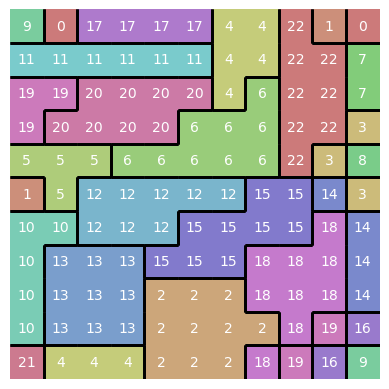

In [11]:
pastel_cmap = myplot.create_pastel_cmap(121)
borders = myplot.find_borders(icc_idx_map)
comms = icc_idx_map.astype(int) #TODO use the values here that indicate how indicative this ICC is
lw = 2
plt.figure()
myplot.draw_all_borders(borders)
myplot.draw_all_values(comms)        
plt.imshow(icc_idx_map, cmap=pastel_cmap)
plt.axis("off")
plt.show()


In [114]:
# difference 3 vs. 5
dif_35 = all_P_icc[:,:,[3,5]].mean(axis=1)
dif_35 = np.diff(dif_35, axis=1).flatten()

# difference in means class 3 vs. rest
dif_3r = all_P_icc.mean(axis=1)
dif_3r = dif_3r[:,3] - dif_3r.mean(axis=1)




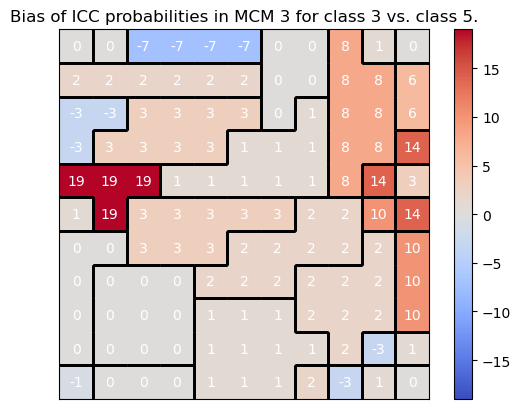

In [115]:
bias = (dif_3r[vals]*100).astype(int) 
absmax =bias.flat[np.abs(bias).argmax()] # scale axis

# diff_map is difference in average probabilities of an ICC over all images of class 3 vs class 5
# FIXME problem is that borders are not enough to indicate which cells are the same ICC because they must not be adjacent

plt.figure()
plt.title("Bias of ICC probabilities in MCM 3 for class 3 vs. class 5.") # plt.title(" Higher values = higher avg P for an image of class 3.")
myplot.draw_all_borders(borders)
myplot.draw_all_values(bias) # OR comms
im = plt.imshow(bias, cmap="coolwarm",vmin=-absmax,vmax=absmax)  # Set the color limits
colorbar = plt.colorbar(im)
plt.xticks([])
plt.yticks([])
plt.show()


In [ ]:
# need a co-occurance matrix of what it was called
# 121 by 121 of how destinctive that pixel is between 3 vs. 5

# 1 matrix = 1 image
# what icc these pixels are part of
